In [18]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# _TODO_
- Try excluding the subjects with fewer trials 
- Try shuffle the trials for generalization or specialize for a single subject for accuracy

# Import EEG data
Imports the `extract.p` file generated by the [extraction notebook](eeg-data/data-extract.ipynb).

Shapes:
- X: `(subject, trials, (fs * mi_duration), channels)`
- y: `(subject, trials)`

In [19]:
import pickle

with open('eeg-data/extract.p', 'rb') as f:
    EEG_raw, y = pickle.load(f)

for i, subj in enumerate(EEG_raw):
    n_trials, n_t, n_ch = subj.shape
    print(f"Subject {i+1}: {n_trials} trials, {n_t} samples, {n_ch} channels")



Subject 1: 1236 trials, 1536 samples, 16 channels
Subject 2: 1960 trials, 1536 samples, 16 channels
Subject 3: 434 trials, 1536 samples, 16 channels
Subject 4: 1464 trials, 1536 samples, 16 channels
Subject 5: 494 trials, 1536 samples, 16 channels
Subject 6: 1126 trials, 1536 samples, 16 channels


Since the number of trials is not equal between the subjects, downsample trials per subject to the minimum by random selection (fixed seed)

In [20]:
def resize_trials(X, y, seed=42):
    rng = np.random.default_rng(seed)
    min_trials = min(s.shape[0] for s in X)
    X_resized, y_resized = [], []
    for subj_X, subj_y in zip(X, y):
        n = subj_X.shape[0]
        idx = np.arange(min_trials) if n == min_trials else rng.choice(n, size=min_trials, replace=False)
        X_resized.append(subj_X[idx])
        y_resized.append(subj_y[idx])
    return np.stack(X_resized), np.stack(y_resized)

EEG_raw, y = resize_trials(EEG_raw, y)
print("After trial resize:")
for i, subj in enumerate(EEG_raw):
    n_trials, n_t, n_ch = subj.shape
    print(f"Subject {i+1}: {n_trials} trials, {n_t} samples, {n_ch} channels")
print("...as a single numpy array of shape:", EEG_raw.shape)

After trial resize:
Subject 1: 434 trials, 1536 samples, 16 channels
Subject 2: 434 trials, 1536 samples, 16 channels
Subject 3: 434 trials, 1536 samples, 16 channels
Subject 4: 434 trials, 1536 samples, 16 channels
Subject 5: 434 trials, 1536 samples, 16 channels
Subject 6: 434 trials, 1536 samples, 16 channels
...as a single numpy array of shape: (6, 434, 1536, 16)


In [21]:
fs = 256
mi_duration = 6
n_subjects, n_trials, n_samples, n_channels = EEG_raw.shape
assert all(subj.shape[1] == fs * mi_duration for subj in EEG_raw), f"Expected {fs * mi_duration} samples per trial"

# Static filters
Notch + Bandpass

In [22]:
# Notch filter to remove 50 Hz power line noise
b_notch, a_notch = signal.iirnotch(50, Q=30, fs=fs)    # Q factor determines the bandwidth of the notch filter

# Band-pass filter between 8-30 Hz
b_bp, a_bp = signal.cheby2(
    N=4,                        # Higher order = sharper cutoff
    rs=40,                      # Stopband attenuation in dB -> Suppress everything outside the passband by at least rs dB
    Wn=[8/(fs/2), 30/(fs/2)],   # Normalized cutoff frequencies (Nyquist frequency = fs/2)
    btype='bandpass'
)

In [23]:
# Apply the filters
EEG_notched = signal.filtfilt(b_notch, a_notch, EEG_raw, axis=2)
EEG_bp = signal.filtfilt(b_bp, a_bp, EEG_raw, axis=2)
EEG_filtered = signal.filtfilt(b_bp, a_bp, EEG_notched, axis=2) # <--- Use this from now on

## Plot filtering effect
Seems like the notch filter doesn't have an effect and could be removed...

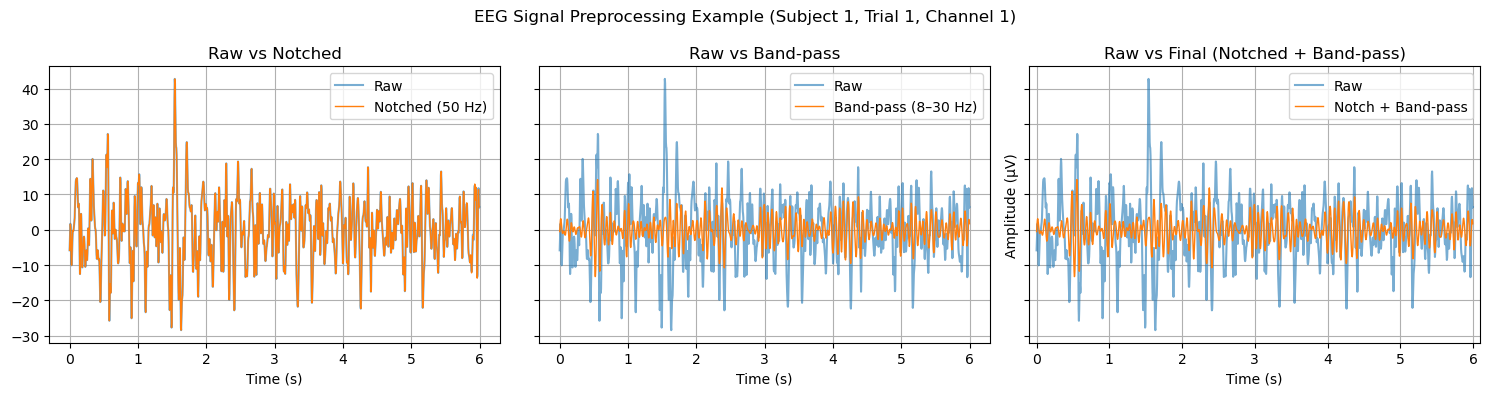

In [24]:
mask = np.zeros(EEG_raw.shape, dtype=bool)
mask[0, 0, :, 0] = True  # example: Subject 1, Trial 1, Channel 1

fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
t = np.arange(EEG_raw.shape[2]) / fs

axs[0].plot(t, EEG_raw[mask], label="Raw", alpha=0.6)
axs[0].plot(t, EEG_notched[mask], label="Notched (50 Hz)", linewidth=1)
axs[0].set_title("Raw vs Notched")
axs[0].set_xlabel("Time (s)")
axs[0].grid(True)
axs[0].legend()

axs[1].plot(t, EEG_raw[mask], label="Raw", alpha=0.6)
axs[1].plot(t, EEG_bp[mask], label="Band-pass (8–30 Hz)", linewidth=1)
axs[1].set_title("Raw vs Band-pass")
axs[1].set_xlabel("Time (s)")
axs[1].grid(True)
axs[1].legend()

axs[2].plot(t, EEG_raw[mask], label="Raw", alpha=0.6)
axs[2].plot(t, EEG_filtered[mask], label="Notch + Band-pass", linewidth=1)
axs[2].set_title("Raw vs Final (Notched + Band-pass)")
axs[2].set_xlabel("Time (s)")
axs[2].set_ylabel("Amplitude (µV)")
axs[2].grid(True)
axs[2].legend()

plt.xlim(-.1, t[-1] + .1)
plt.suptitle("EEG Signal Preprocessing Example (Subject 1, Trial 1, Channel 1)")
plt.tight_layout()
plt.show()

# Spatial filters 

## PCA
It finds linear combinations of channels that explain maximal variance across all rows.

Translated to EEG language:
- PCA is learning spatial patterns, weighted sums of electrodes
- variance is computed over time points and trials, pooled across subjects
- because of per subject normalization, variance that is purely “this subject has stronger signals” is suppressed

So PCA is capturing:
- spatial covariance structure that is consistent across subjects
- dominant channel co activations over time

In [25]:
# Per-subject normalization
X = []
means, stds = [], []

for s in range(n_subjects):
    part = EEG_filtered[s].reshape(-1, n_channels).copy()
    m = part.mean(axis=0); sd = part.std(axis=0)
    means.append(m); stds.append(sd)
    X.append((part - m) / sd)

X = np.vstack(X)
X.shape # shape: (n_subjects * n_trials * n_samples, n_channels)

(3999744, 16)

In [37]:
from sklearn.decomposition import PCA

threshold_expl_var = 0.95
pca = PCA().fit(X)
X_pca = pca.transform(X)

# Pick number of components to retain 95% variance
cumul_expl_var = np.cumsum(pca.explained_variance_ratio_)
n_components = np.searchsorted(cumul_expl_var, threshold_expl_var) + 1
X_pca = X_pca[:, :n_components]
print(f"Number of components selected in order to retain {threshold_expl_var*100}% variance -> {n_components}")

# Reshape back to (n_subjects, n_trials, n_samples, n_components)
X_pca = X_pca.reshape(n_subjects, n_trials, n_samples, n_components) # shape: (n_subjects, n_trials, n_samples, n_components)
assert X_pca.shape[-1] < n_channels, "PCA did not reduce dimensionality as expected!"
X_pca.shape

Number of components selected in order to retain 95.0% variance -> 6


(6, 434, 1536, 6)

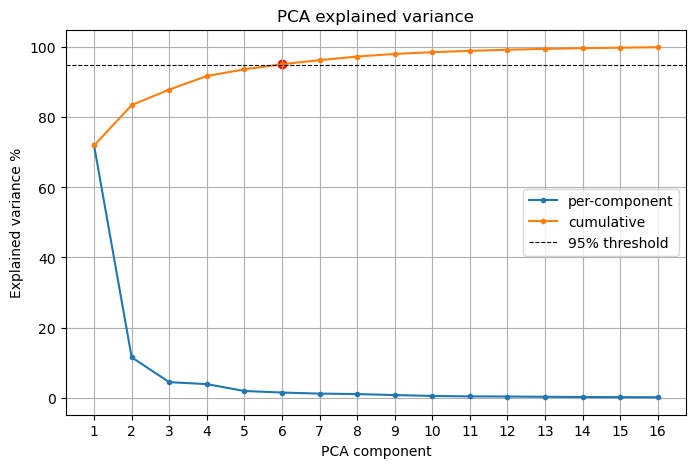

In [ ]:
def plot_pca_explained(pca, threshold=95):
    explained = pca.explained_variance_ratio_ * 100
    cum = np.cumsum(explained)
    comps = np.arange(1, len(explained) + 1)

    plt.figure(figsize=(8,5))
    plt.plot(comps, explained, marker='o', markersize=3, label='per-component')
    plt.plot(comps, cum, marker='o', markersize=3, label='cumulative')
    plt.axhline(threshold, color='k', linestyle='--', linewidth=0.8, label=f'{threshold}% threshold')

    n_comp = np.searchsorted(cum, threshold) + 1
    plt.scatter(n_comp, cum[n_comp-1], color='r')
    plt.xlabel('PCA component')
    plt.xticks(np.arange(1, len(explained)+1))
    plt.ylabel('Explained variance %')
    plt.title('PCA explained variance')
    plt.grid(True)
    plt.legend()
    plt.show()

n_components = plot_pca_explained(pca)

## Plot filtering effect